<a href="https://colab.research.google.com/github/dantonnoriega/csulb-data-day-2025/blob/develop/danton_solutions_csulb_data_day_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSULB Data Day 2025
*(Danton's Break Out Session)*


**Motivating Questions**
> Which compute instance profile strategy (`cost_efficient`, `balanced`, `performance`) would you recommend for each compute request scenarios (`low`, `normal`, `high`)?

> What if you could choose only one strategy?

### Learning Goals

* **Exposure to industry-inspired questions** about the cost and usage of compute infrastructure
* **Work with relevant data** (albiet simplified and simulated) virtually all tech companies are analyzing
* **Practice coding with AI** and understanding the trade-offs and pitfalls
  * AI Assistants are good enough that one can now "vibecode" (code using English)
  * This is *adventagous* for experienced data scientist but *can be disadvantagous* to newer ones
* **Learn about [`polars`](https://docs.pola.rs/api/python/stable/reference/index.html) and [`Claude AI`](https://claude.ai)**, my favorite package for working with data frames and my favorite AI assistant!
  * And [`plotnine`](https://plotnine.org/) for ggplot2-style ("grammar of graphics") plotting


In [34]:
# GOAL:
# - find the best instance allocation strategy for each request scenario: low, normal, high

# General Set Up
import polars as pl
import plotnine as p9

In [35]:
# prompt: read in a csv as `scenarios_df` with polars from a public repo url: `https://github.com/dantonnoriega/csulb-data-day-2025/blob/main/data/compute_request_scenarios.csv`
# tip: try_parse_dates=True

scenarios_df = pl.read_csv("https://raw.githubusercontent.com/dantonnoriega/csulb-data-day-2025/main/data/compute_request_scenarios.csv", try_parse_dates=True)
print(scenarios_df)

shape: (13_032, 3)
┌─────────────────────┬──────────┬──────────┐
│ datetime            ┆ scenario ┆ requests │
│ ---                 ┆ ---      ┆ ---      │
│ datetime[μs]        ┆ str      ┆ i64      │
╞═════════════════════╪══════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ normal   ┆ 2519     │
│ 2023-01-01 01:00:00 ┆ normal   ┆ 1577     │
│ 2023-01-01 02:00:00 ┆ normal   ┆ 1277     │
│ 2023-01-01 03:00:00 ┆ normal   ┆ 921      │
│ 2023-01-01 04:00:00 ┆ normal   ┆ 781      │
│ …                   ┆ …        ┆ …        │
│ 2023-06-30 19:00:00 ┆ low      ┆ 14314    │
│ 2023-06-30 20:00:00 ┆ low      ┆ 14153    │
│ 2023-06-30 21:00:00 ┆ low      ┆ 11300    │
│ 2023-06-30 22:00:00 ┆ low      ┆ 11039    │
│ 2023-06-30 23:00:00 ┆ low      ┆ 8149     │
└─────────────────────┴──────────┴──────────┘


In [36]:
# prompt: add a "year-month" column `ym` using column `datetime` to data frame `scenarios_df`

scenarios_df = scenarios_df.with_columns(
    pl.col("datetime").dt.strftime("%Y-%m").alias("ym")
)
print(scenarios_df)


shape: (13_032, 4)
┌─────────────────────┬──────────┬──────────┬─────────┐
│ datetime            ┆ scenario ┆ requests ┆ ym      │
│ ---                 ┆ ---      ┆ ---      ┆ ---     │
│ datetime[μs]        ┆ str      ┆ i64      ┆ str     │
╞═════════════════════╪══════════╪══════════╪═════════╡
│ 2023-01-01 00:00:00 ┆ normal   ┆ 2519     ┆ 2023-01 │
│ 2023-01-01 01:00:00 ┆ normal   ┆ 1577     ┆ 2023-01 │
│ 2023-01-01 02:00:00 ┆ normal   ┆ 1277     ┆ 2023-01 │
│ 2023-01-01 03:00:00 ┆ normal   ┆ 921      ┆ 2023-01 │
│ 2023-01-01 04:00:00 ┆ normal   ┆ 781      ┆ 2023-01 │
│ …                   ┆ …        ┆ …        ┆ …       │
│ 2023-06-30 19:00:00 ┆ low      ┆ 14314    ┆ 2023-06 │
│ 2023-06-30 20:00:00 ┆ low      ┆ 14153    ┆ 2023-06 │
│ 2023-06-30 21:00:00 ┆ low      ┆ 11300    ┆ 2023-06 │
│ 2023-06-30 22:00:00 ┆ low      ┆ 11039    ┆ 2023-06 │
│ 2023-06-30 23:00:00 ┆ low      ┆ 8149     ┆ 2023-06 │
└─────────────────────┴──────────┴──────────┴─────────┘


In [37]:
# prompt: reorder columns in `scenarios_df` as `datetime`, `ym`, `scenario`, `requests`

scenarios_df = scenarios_df.select(['datetime', 'ym', 'scenario', 'requests'])
print(scenarios_df)


shape: (13_032, 4)
┌─────────────────────┬─────────┬──────────┬──────────┐
│ datetime            ┆ ym      ┆ scenario ┆ requests │
│ ---                 ┆ ---     ┆ ---      ┆ ---      │
│ datetime[μs]        ┆ str     ┆ str      ┆ i64      │
╞═════════════════════╪═════════╪══════════╪══════════╡
│ 2023-01-01 00:00:00 ┆ 2023-01 ┆ normal   ┆ 2519     │
│ 2023-01-01 01:00:00 ┆ 2023-01 ┆ normal   ┆ 1577     │
│ 2023-01-01 02:00:00 ┆ 2023-01 ┆ normal   ┆ 1277     │
│ 2023-01-01 03:00:00 ┆ 2023-01 ┆ normal   ┆ 921      │
│ 2023-01-01 04:00:00 ┆ 2023-01 ┆ normal   ┆ 781      │
│ …                   ┆ …       ┆ …        ┆ …        │
│ 2023-06-30 19:00:00 ┆ 2023-06 ┆ low      ┆ 14314    │
│ 2023-06-30 20:00:00 ┆ 2023-06 ┆ low      ┆ 14153    │
│ 2023-06-30 21:00:00 ┆ 2023-06 ┆ low      ┆ 11300    │
│ 2023-06-30 22:00:00 ┆ 2023-06 ┆ low      ┆ 11039    │
│ 2023-06-30 23:00:00 ┆ 2023-06 ┆ low      ┆ 8149     │
└─────────────────────┴─────────┴──────────┴──────────┘


In [38]:
# prompt: sum `requests` by `ym` and `scenario`, sort, then save as object `scenarios_by_ym_df`

scenarios_by_ym_df = (
    scenarios_df
    .group_by(["ym", "scenario"])
    .agg(pl.col("requests").sum())
    .sort(["ym", "scenario"])
)
print(scenarios_by_ym_df)

shape: (18, 3)
┌─────────┬──────────┬──────────┐
│ ym      ┆ scenario ┆ requests │
│ ---     ┆ ---      ┆ ---      │
│ str     ┆ str      ┆ i64      │
╞═════════╪══════════╪══════════╡
│ 2023-01 ┆ high     ┆ 13233871 │
│ 2023-01 ┆ low      ┆ 5926782  │
│ 2023-01 ┆ normal   ┆ 8467319  │
│ 2023-02 ┆ high     ┆ 12981016 │
│ 2023-02 ┆ low      ┆ 5742298  │
│ …       ┆ …        ┆ …        │
│ 2023-05 ┆ low      ┆ 8265850  │
│ 2023-05 ┆ normal   ┆ 11808854 │
│ 2023-06 ┆ high     ┆ 19091652 │
│ 2023-06 ┆ low      ┆ 8604596  │
│ 2023-06 ┆ normal   ┆ 12292739 │
└─────────┴──────────┴──────────┘


In [39]:
# prompt: use polars `.sql` to sum `requests` in dataframe `scenarios_df` grouped by `ym` and `scenario`, sort, then save as object `scenarios_by_ym_df`
# (edits required)
scenarios_by_ym_df = scenarios_df.sql(
    """
    SELECT ym, scenario, SUM(requests) as requests
    FROM self
    GROUP BY ym, scenario
    ORDER BY ym, scenario
    """
)
print(scenarios_by_ym_df)

shape: (18, 3)
┌─────────┬──────────┬──────────┐
│ ym      ┆ scenario ┆ requests │
│ ---     ┆ ---      ┆ ---      │
│ str     ┆ str      ┆ i64      │
╞═════════╪══════════╪══════════╡
│ 2023-01 ┆ high     ┆ 13233871 │
│ 2023-01 ┆ low      ┆ 5926782  │
│ 2023-01 ┆ normal   ┆ 8467319  │
│ 2023-02 ┆ high     ┆ 12981016 │
│ 2023-02 ┆ low      ┆ 5742298  │
│ …       ┆ …        ┆ …        │
│ 2023-05 ┆ low      ┆ 8265850  │
│ 2023-05 ┆ normal   ┆ 11808854 │
│ 2023-06 ┆ high     ┆ 19091652 │
│ 2023-06 ┆ low      ┆ 8604596  │
│ 2023-06 ┆ normal   ┆ 12292739 │
└─────────┴──────────┴──────────┘


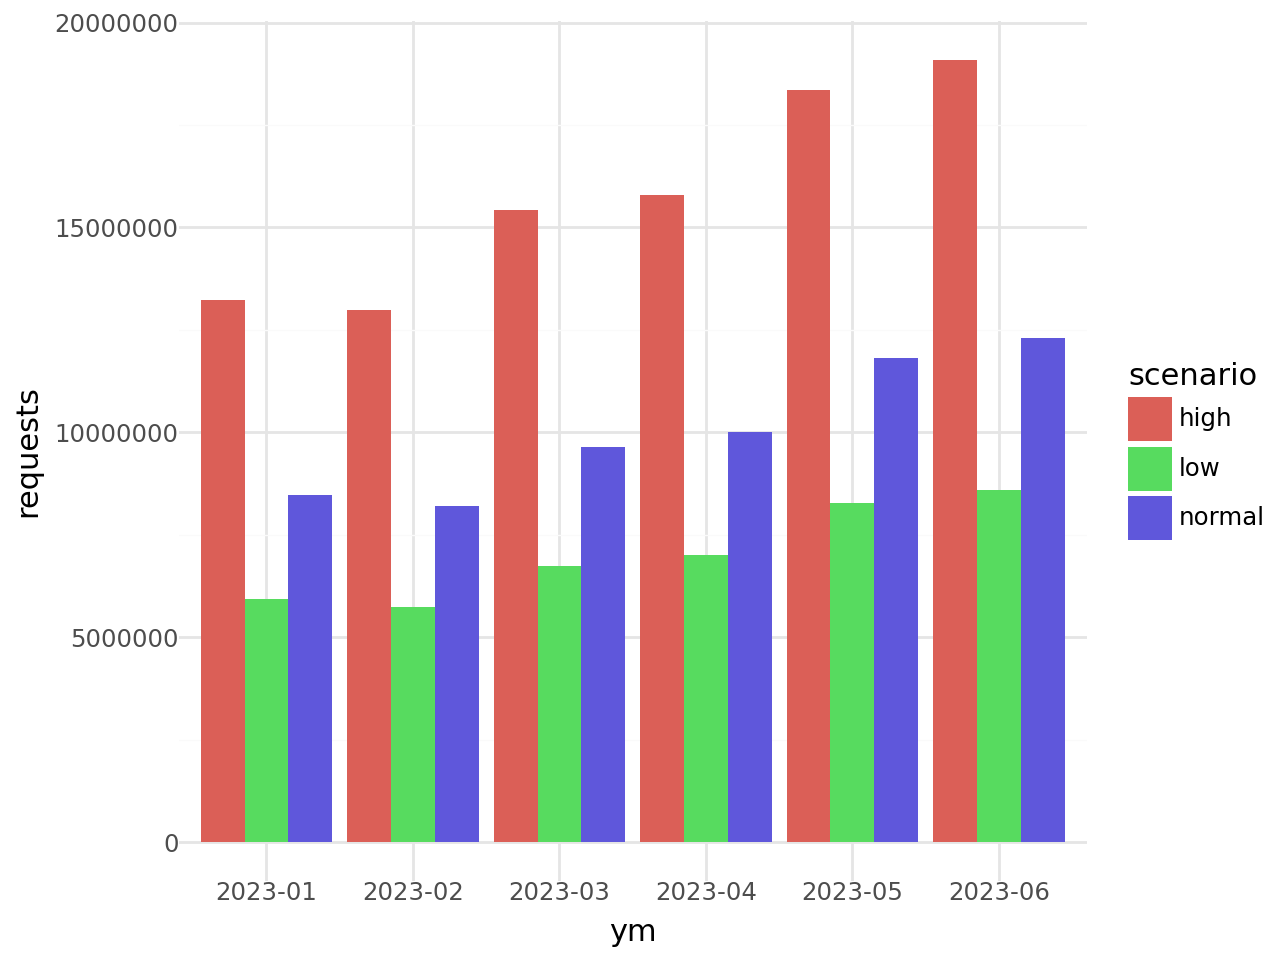

In [40]:
# prompt: create a bar plot with x = "ym" and y = "requests" grouped by "scenario" using dataframe `scenarios_by_ym_df` with minimal theme

(
    p9.ggplot(scenarios_by_ym_df, p9.aes(x="ym", y="requests", fill="scenario"))
    + p9.geom_col(position="dodge")
    + p9.theme_minimal()
)


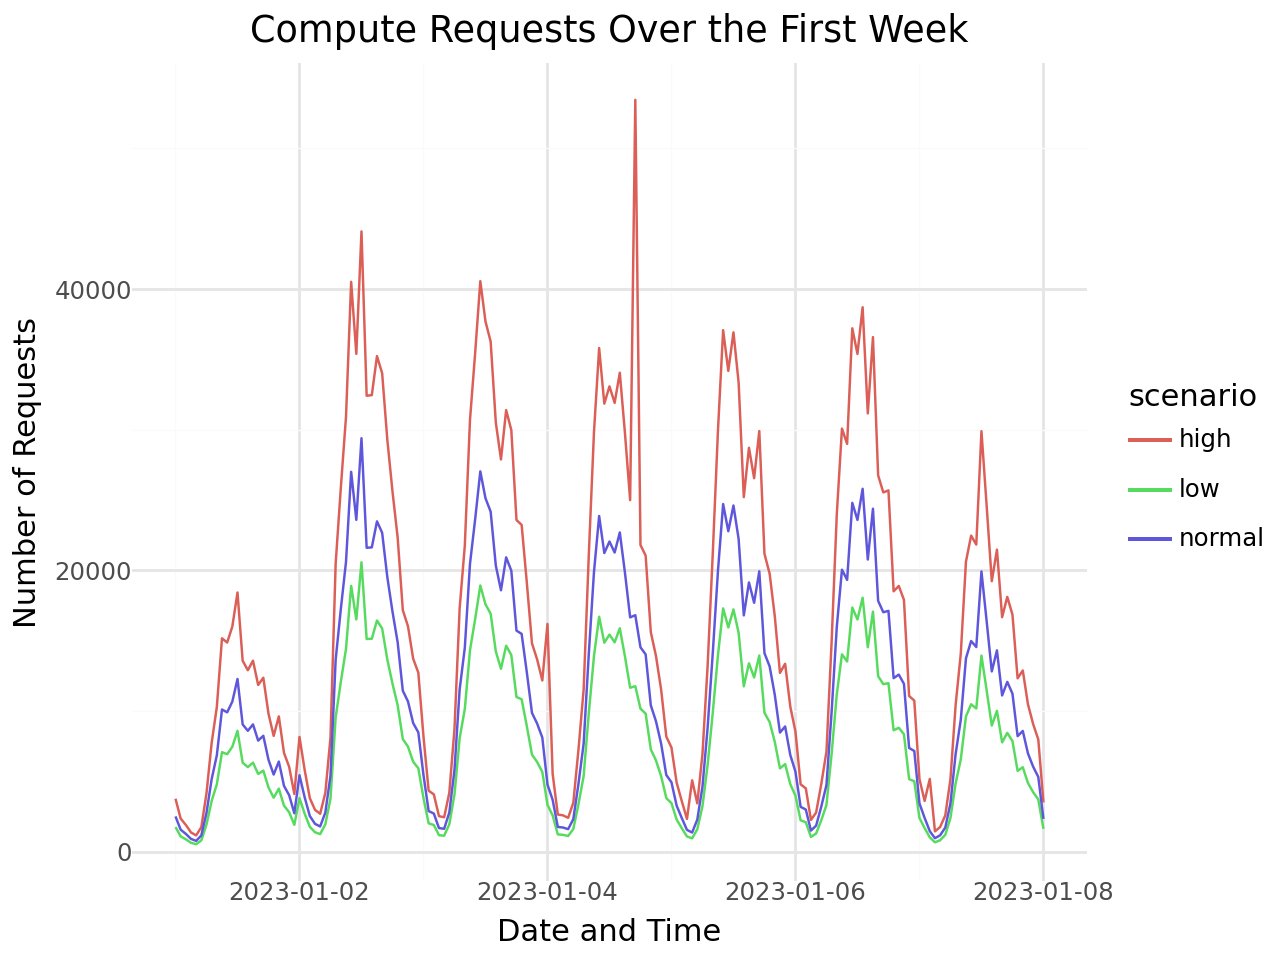

In [41]:
# prompt: filter data frame `scenarios_df` to the first week of data then create a line plot using plotnine grouped by `scenario` with x = "datetime" and y = "requests"

# Filter data to the first week
first_week_df = scenarios_df.filter(
    pl.col("datetime") <= scenarios_df["datetime"].min() + pl.duration(days=7)
)

# Create the line plot using plotnine
(
    p9.ggplot(first_week_df, p9.aes(x="datetime", y="requests", color="scenario"))
    + p9.geom_line()
    + p9.labs(
        title="Compute Requests Over the First Week",
        x="Date and Time",
        y="Number of Requests",
    )
    + p9.theme_minimal()
)


## Determine Allocations (Challenge)

In [42]:
# Instance Allocation Strategies ----------------------

# Strategy 1: Cost Efficiency - Many smaller instances
cost_efficiency_allocation = {
    "micro": 25,
    "small": 20,
    "medium": 17,
    "large": 6,
    "xlarge": 1
}

# Strategy 2: Performance - Fewer, more powerful instances
performance_allocation = {
    "micro": 0,
    "small": 0,
    "medium": 0,
    "large": 6,
    "xlarge": 15
}

# Strategy 3: Balanced - Mix of instance types
balanced_allocation = {
    "micro": 10,
    "small": 15,
    "medium": 8,
    "large": 5,
    "xlarge": 7
}

In [43]:
# instruction:
## - read the csv file at https://github.com/dantonnoriega/csulb-data-day-2025/blob/main/data/compute_instance_profiles.csv
## - to object named `instances_df` and print it

instances_df = pl.read_csv("https://raw.githubusercontent.com/dantonnoriega/csulb-data-day-2025/main/data/compute_instance_profiles.csv")
print(instances_df)

shape: (5, 3)
┌───────────────┬───────────────────┬───────────────┐
│ instance_type ┆ requests_per_hour ┆ cost_per_hour │
│ ---           ┆ ---               ┆ ---           │
│ str           ┆ i64               ┆ f64           │
╞═══════════════╪═══════════════════╪═══════════════╡
│ micro         ┆ 100               ┆ 0.012         │
│ small         ┆ 250               ┆ 0.024         │
│ medium        ┆ 600               ┆ 0.048         │
│ large         ┆ 1500              ┆ 0.096         │
│ xlarge        ┆ 4000              ┆ 0.192         │
└───────────────┴───────────────────┴───────────────┘


In [44]:
# prompt: create a new polars dataframe with columns `strategy`, `hourly_capacity`, `hourly_cost` that iterates over dicts `cost_efficiency_allocation`, `performance_allocation`, `balanced_allocation` and matches keys to column `instance_type` in dataframe `instances_df` with columns `instance_type`, `requests_per_hour`, `cost_per_hour`
# (edits required)

allocation_strategies = {
    "cost_efficiency": cost_efficiency_allocation,
    "performance": performance_allocation,
    "balanced": balanced_allocation
}

rows = []
for strategy, allocation in allocation_strategies.items():
  for instance_type, count in allocation.items():
    instance_row = instances_df.filter(pl.col("instance_type") == instance_type)
    hourly_capacity = instance_row["requests_per_hour"].item() * count
    hourly_cost = instance_row["cost_per_hour"].item() * count
    rows.append({"strategy": strategy, "hourly_capacity": hourly_capacity, "hourly_cost": hourly_cost})

allocation_df = (
    pl.DataFrame(rows)
    .group_by('strategy')
    .agg(
        pl.col('hourly_capacity').sum(),
        pl.col('hourly_cost').sum()
    )
)
allocation_df


strategy,hourly_capacity,hourly_cost
str,i64,f64
"""performance""",69000,3.456
"""cost_efficiency""",30700,2.364
"""balanced""",45050,2.688


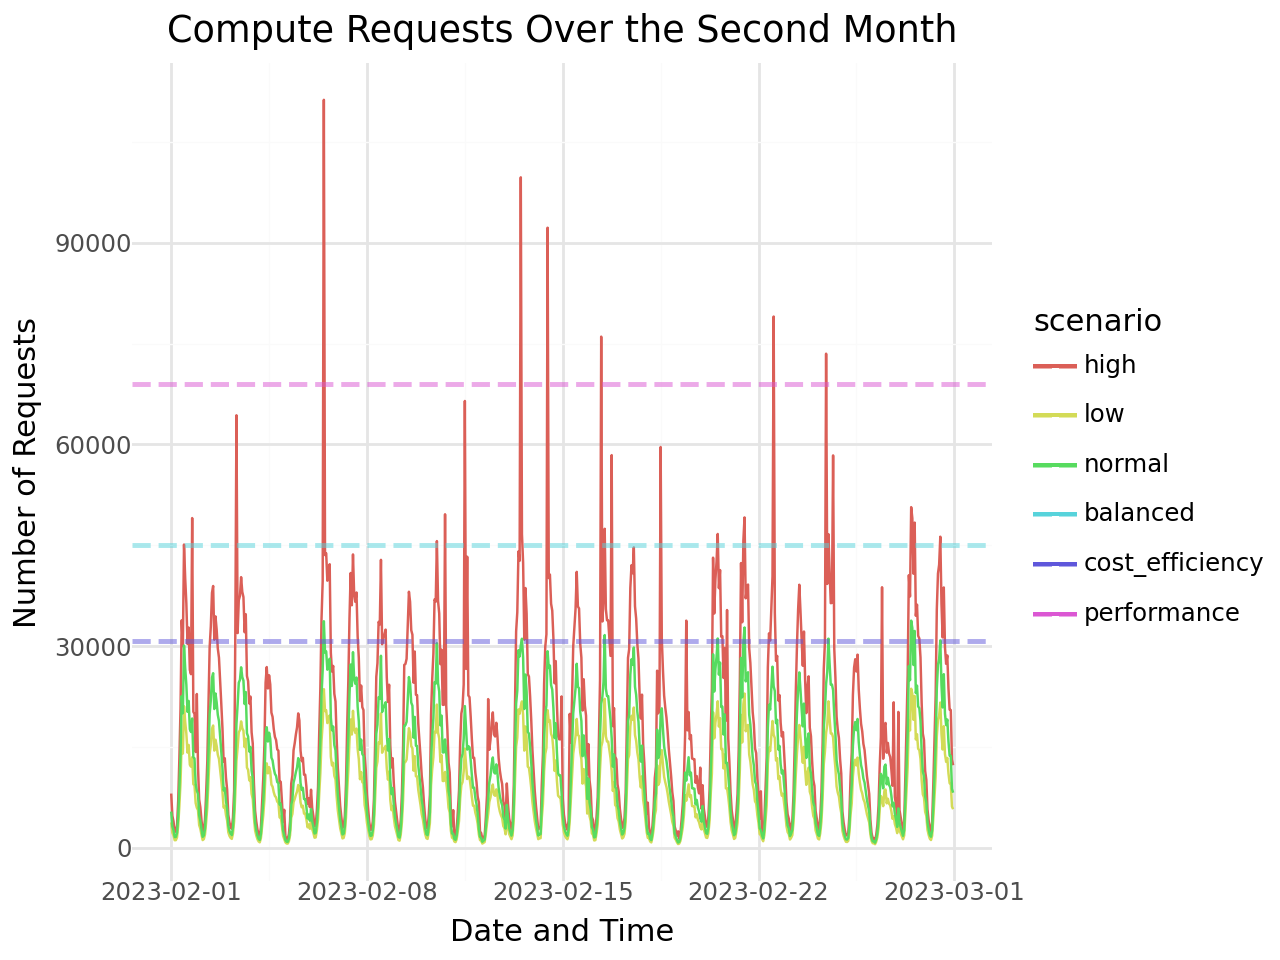

In [62]:
# prompt: filter data frame `scenarios_df` to the second month of data then create a line plot using plotnine grouped by `scenario` with x = "datetime" and y = "requests". finally, layer in horizontal lines where y = "hourly_capacity" grouped by `strategy`
# (edits required)

second_month_df = scenarios_df.filter(
    pl.col("datetime").dt.month() == 2
)

(
    p9.ggplot()
    + p9.geom_line(
        p9.aes(x="datetime", y="requests", color="scenario"),
        data=second_month_df
      )
    + p9.geom_hline(
        p9.aes(yintercept="hourly_capacity", color="strategy"),
        linetype="dashed",
        size=1,
        alpha=0.5,
        data=allocation_df
    )
    + p9.labs(
        title="Compute Requests Over the Second Month",
        x="Date and Time",
        y="Number of Requests",
    )
    + p9.theme_minimal()
)


In [46]:
# prompt: determine the overall `service_rate = 1 - (unserved_requests / total_requests)` for each strategy and scenario, where `unserved_requests` are all hourly requests above `hourly_capacity` and zero otherwise
# (edits required)

# Merge scenarios_df and allocation_df
merged_df = scenarios_df.join(allocation_df, how="cross")

# Calculate unserved requests
merged_df = merged_df.with_columns(
    pl.when(pl.col("requests") > pl.col("hourly_capacity"))
    .then(pl.col("requests") - pl.col("hourly_capacity"))
    .otherwise(0)
    .alias("unserved_requests")
)

# Group by strategy and scenario to calculate service rate
service_rate_df = (
    merged_df
    .group_by(["strategy", "scenario"])
    .agg(
        [
            pl.col("requests").sum().alias("total_requests"),
            pl.col("unserved_requests").sum().alias("unserved_requests")
        ]
    )
    .with_columns(
        (1 - (pl.col("unserved_requests") / pl.col("total_requests"))).round(4).alias("service_rate")
    )
    .select(["strategy", "scenario", "service_rate"])
)

print(service_rate_df.sort(['strategy','scenario']))


shape: (9, 3)
┌─────────────────┬──────────┬──────────────┐
│ strategy        ┆ scenario ┆ service_rate │
│ ---             ┆ ---      ┆ ---          │
│ str             ┆ str      ┆ f64          │
╞═════════════════╪══════════╪══════════════╡
│ balanced        ┆ high     ┆ 0.9548       │
│ balanced        ┆ low      ┆ 1.0          │
│ balanced        ┆ normal   ┆ 0.9999       │
│ cost_efficiency ┆ high     ┆ 0.8402       │
│ cost_efficiency ┆ low      ┆ 0.9999       │
│ cost_efficiency ┆ normal   ┆ 0.98         │
│ performance     ┆ high     ┆ 0.9912       │
│ performance     ┆ low      ┆ 1.0          │
│ performance     ┆ normal   ┆ 1.0          │
└─────────────────┴──────────┴──────────────┘


## Solution

In [47]:
import polars as pl
import io

# Paste your CSV data here
csv_data = """scenario,strategy,service_rate
high,balanced,0.9548
high,cost_efficiency,0.8402
high,performance,0.9912
low,balanced,1.0
low,cost_efficiency,0.9999
low,performance,1.0
normal,balanced,0.9999
normal,cost_efficiency,0.98
normal,performance,1.0
"""

# Create a BytesIO object from the string
csv_file = io.StringIO(csv_data)

# Read the CSV data into a Polars DataFrame
service_rate_df = pl.read_csv(csv_file)
print(service_rate_df.sort(['strategy','scenario']))

shape: (9, 3)
┌──────────┬─────────────────┬──────────────┐
│ scenario ┆ strategy        ┆ service_rate │
│ ---      ┆ ---             ┆ ---          │
│ str      ┆ str             ┆ f64          │
╞══════════╪═════════════════╪══════════════╡
│ high     ┆ balanced        ┆ 0.9548       │
│ low      ┆ balanced        ┆ 1.0          │
│ normal   ┆ balanced        ┆ 0.9999       │
│ high     ┆ cost_efficiency ┆ 0.8402       │
│ low      ┆ cost_efficiency ┆ 0.9999       │
│ normal   ┆ cost_efficiency ┆ 0.98         │
│ high     ┆ performance     ┆ 0.9912       │
│ low      ┆ performance     ┆ 1.0          │
│ normal   ┆ performance     ┆ 1.0          │
└──────────┴─────────────────┴──────────────┘
